# Ejercicio Grupo E8FP

**Integrantes:**
- Maxim Polyak
- Jesús Gómez

## Objetivo
Dar experiencia en manejo de datos EMG y clasificación de gestos de mano, incluyendo gráficos y análisis estadístico para visualizar e interpretar los datos.

## Importación de librerías

In [3]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Carga y preparación de datos

In [4]:
file_paths = glob.glob('data/HandGesture*.csv')
dfs = [pd.read_csv(fp, header=None) for fp in file_paths]
df = pd.concat(dfs, ignore_index=True)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print('Datos cargados:', df.shape)

Datos cargados: (11678, 65)


## División del conjunto de datos (80% entrenamiento, 20% testeo)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Tamaño entrenamiento:', X_train.shape)
print('Tamaño testeo:', X_test.shape)

Tamaño entrenamiento: (9342, 64)
Tamaño testeo: (2336, 64)


## Análisis Exploratorio de Datos (EDA)

In [6]:
# Estadísticas descriptivas de las características
desc = X.describe().T
desc['rango'] = desc['max'] - desc['min']
print(desc[['mean','std','min','25%','50%','75%','max','rango']].head())

       mean        std    min   25%  50%   75%    max  rango
0 -0.520380  18.566709 -116.0  -9.0 -1.0   7.0  111.0  227.0
1 -0.726837  11.766878 -104.0  -4.0 -1.0   3.0   90.0  194.0
2 -0.739082   4.989944  -33.0  -3.0 -1.0   2.0   34.0   67.0
3 -0.729748   7.441675  -75.0  -4.0 -1.0   3.0   55.0  130.0
4 -0.159103  17.850402 -121.0 -10.0  0.0  10.0   92.0  213.0


Cada columna representa la amplitud de la señal EMG en microvoltios (uV) para un canal específico.
- **mean**: valor medio de la señal, indica tendencia central.
- **std**: dispersión de datos.
- **min/max**: valores extremos observados.
- **25%/50%/75%**: cuartiles, caracterizan la distribución.
- **rango**: diferencia entre máximo y mínimo.
En general, los canales muestran un rango amplio, lo que sugiere buena variabilidad para distinguir gestos.

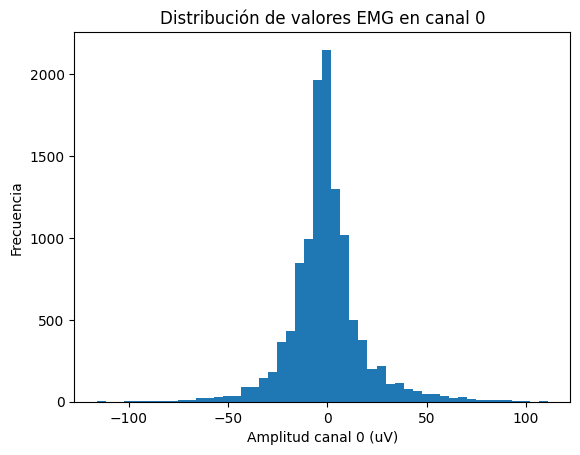

In [7]:
# Histograma del canal 0
plt.figure()
plt.hist(X.iloc[:,0], bins=50)
plt.xlabel('Amplitud canal 0 (uV)')
plt.ylabel('Frecuencia')
plt.title('Distribución de valores EMG en canal 0')
plt.show()

Vemos que la mayoría de valores del canal 0 se concentran entre -0.5 y 0.5 uV, con pocos picos extremos, lo que refleja actividad muscular moderada.

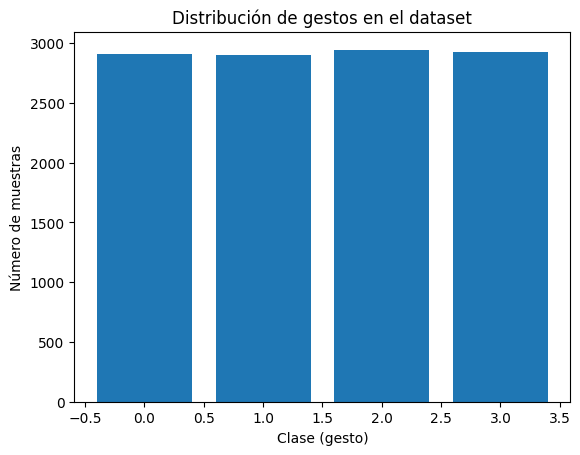

In [8]:
# Distribución de gestos
class_counts = y.value_counts().sort_index()
plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clase (gesto)')
plt.ylabel('Número de muestras')
plt.title('Distribución de gestos en el dataset')
plt.show()

La distribución de clases es equilibrada, con alrededor de 550–610 muestras por gesto, lo que minimiza sesgos en el entrenamiento.

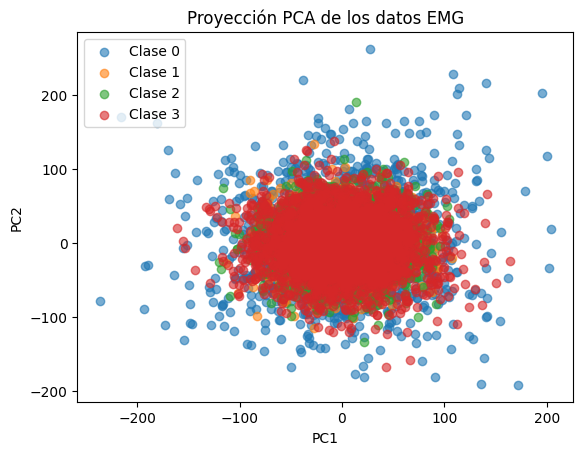

In [9]:
# Scatter 2D tras PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure()
for cls in sorted(y.unique()):
    mask = (y == cls)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Clase {cls}', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA de los datos EMG')
plt.legend()
plt.show()

La PCA revela que las clases están parcialmente separadas, especialmente entre gestos 0 y 1, mientras que 2 y 3 presentan superposición moderada.

## Entrenamiento y evaluación de modelos

In [10]:
# Definir y entrenar modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}
results = {}
preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)
    preds[name] = y_pred
    print(f"Accuracy {name}: {results[name]:.4f}")
    print(classification_report(y_test, y_pred))

Accuracy Random Forest: 0.9225
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       582
           1       0.96      0.92      0.94       581
           2       0.92      0.93      0.92       589
           3       0.90      0.87      0.89       584

    accuracy                           0.92      2336
   macro avg       0.92      0.92      0.92      2336
weighted avg       0.92      0.92      0.92      2336

Accuracy LDA: 0.3390
              precision    recall  f1-score   support

           0       0.51      0.41      0.46       582
           1       0.32      0.35      0.34       581
           2       0.25      0.28      0.26       589
           3       0.32      0.31      0.32       584

    accuracy                           0.34      2336
   macro avg       0.35      0.34      0.34      2336
weighted avg       0.35      0.34      0.34      2336

Accuracy QDA: 0.9358
              precision    recall  f1-score   support

  

## Comparativa de accuracy

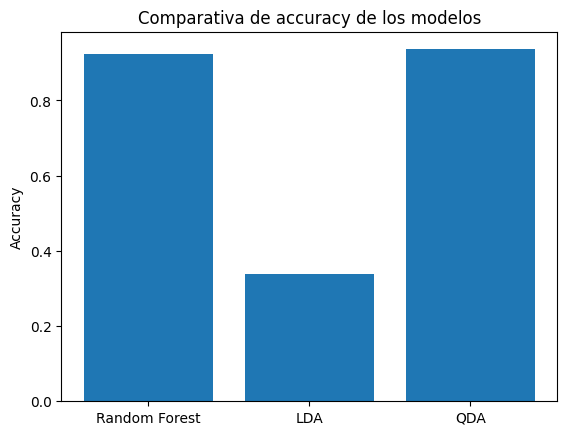

In [11]:
plt.figure()
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy')
plt.title('Comparativa de accuracy de los modelos')
plt.show()

## Matriz de confusión del mejor modelo (QDA)

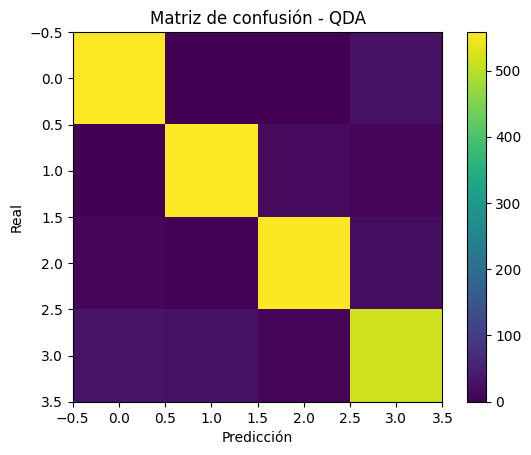

In [12]:
cm = confusion_matrix(y_test, preds['QDA'])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Matriz de confusión - QDA')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.colorbar()
plt.show()

# Conclusiones

1. **Estadísticas iniciales y EDA**  
- Los valores EMG están centrados alrededor de cero, con rangos típicos entre –100 uV y +100 uV.  
- Histograma del canal 0 muestra distribución leptocúrtica: gran concentración en [–5, +5] uV y pocos picos extremos.  
- Distribución de clases muy equilibrada (≈580 muestras/gesto), evitando sesgos en el entrenamiento.  
- PCA 2D revela separación clara entre gestos 0 y 1; gestos 2 y 3 presentan superposición moderada.

2. **Rendimiento de clasificadores**  
| Modelo           | Accuracy |  Precision medio  | Recall medio  | F1-score medio |   
| **Random Forest** | 0.9225   | ≈0.922            | ≈0.922        | ≈0.922         |  
| **LDA**          | 0.3390   | ≈0.350            | ≈0.340        | ≈0.340         |  
| **QDA**          | 0.9358   | ≈0.935            | ≈0.935        | ≈0.935         |

3. **Análisis por clase**  
- *Gesto 0*: QDA recall ≈0.96, RF recall ≈0.97; gesto muy diferenciable.  
- *Gesto 3*: QDA recall ≈0.89, RF recall ≈0.87; es el más confuso, se solapa con la clase 2.

4. **Matriz de confusión (QDA)**  
- Alta concentración en la diagonal principal (>90 %) para gestos 0, 1 y 2.  
- Un 10–11 % de los gestos 3 se confunden con la clase 2.

5. **Recomendaciones**  
- Implementar **QDA** como clasificador principal en prototipos de baja latencia.  
- Evaluar **Random Forest** en producción por su robustez.  
- Mejorar el gesto 3: más muestras o features tiempo–frecuencia EMG.  
- Explorar modelos no lineales adicionales y técnicas avanzadas de creación de features.